In [16]:
"""
Hello y'all see this?
"""
from google.colab import drive
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
# Connect Colab to Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Unzip training data, run once
#!unzip drive/MyDrive/data/train.zip -d drive/MyDrive/data/

In [4]:
# Unzip validation data, run once
#!unzip drive/MyDrive/data/validation.zip -d drive/MyDrive/data/

In [6]:
# This code chunk puts absolute paths of all training/validation images and
# their labels in seperate dataframes
train_paths = []
train_labels = []
validation_paths = []
validation_labels = []
troot = 'drive/MyDrive/data/train-cropped'
vroot = 'drive/MyDrive/data/validation-cropped'

for f in os.listdir(troot):
  #tpath = os.path.join(troot, f)
  tlabel = f[-10:-8]
  train_paths.append(f)
  train_labels.append(tlabel)

for f in os.listdir(vroot):
  #vpath = os.path.join(vroot, f)
  vlabel = f[-10:-8]
  validation_paths.append(f)
  validation_labels.append(vlabel)

train_images = pd.DataFrame({'path': train_paths,
                             'label': train_labels})
validation_images = pd.DataFrame({'path': validation_paths,
                                  'label': validation_labels})

In [7]:
def get_subset(n, data, seed=123):
  """
  input: number of samples, dataframe to be sampled from

  output: subset of rows from dataframe
  """
  random.seed(seed)
  sub = random.sample(range(data.shape[0] + 1), n)
  return data.iloc[sub,:]

In [8]:
imageWidth, imageHeight = 128, 128
channel = 1
imageSize = (imageWidth, imageHeight)
nCategories = 5

# Create model
model = Sequential()

model.add(Conv2D(filters = 64,
                 kernel_size=2,
                 activation='relu',
                 input_shape=(imageWidth, imageHeight, channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(16,
                 kernel_size = 2,
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

#model.add(Conv2D(filters = 128,
#                 kernel_size=2,
#                 activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(nCategories, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      320       
                                                                 
 batch_normalization (Batch  (None, 127, 127, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 16)        4112      
                                                                 
 batch_normalization_1 (Bat  (None, 62, 62, 16)        6

In [9]:
# Prepare training data generator

train_subset = get_subset(1000, train_images)

train_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe = train_subset,
    directory = troot,         # `train_subset` contains absolute paths
    x_col='path',
    y_col='label',
    class_mode='categorical',  # target is 2-D array of one-hot encoded labels
    target_size=imageSize,
    color_mode="grayscale",
    shuffle=False
    )
label_map = train_generator.class_indices

Found 1000 validated image filenames belonging to 5 classes.


In [10]:
## Model Training:
history = model.fit(
    train_generator,
    epochs = 1
)

32/32 [==============================] - 391s 12s/step - loss: 0.8530 - accuracy: 0.7140


In [11]:
# Prepare validation data generator

validation_subset = get_subset(1000, validation_images)

validation_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe = validation_subset,
    directory = vroot,
    x_col='path',
    class_mode= None,
    target_size=imageSize,
    color_mode="grayscale",
    shuffle=False
    )

Found 1000 validated image filenames.


In [12]:
## Make categorical prediction:
print(" --- Predicting on validation data ---")
phat = model.predict(validation_generator)
print("Predicted probability array shape:", phat.shape)
print("Example:\n", phat[:5])

 --- Predicting on validation data ---
32/32 [==============================] - 392s 13s/step
Predicted probability array shape: (1000, 5)
Example:
 [[0.1616296  0.30998984 0.05372012 0.29823014 0.17643023]
 [0.13615686 0.26374972 0.03656844 0.3991969  0.16432808]
 [0.15542267 0.32271892 0.0545074  0.30187035 0.16548064]
 [0.15600596 0.2831137  0.03894683 0.33829355 0.18363994]
 [0.13902032 0.271856   0.03782312 0.38506874 0.1662318 ]]


In [13]:
## Convert labels to categories:
validation_subset['predicted'] = pd.Series(np.argmax(phat, axis=1),
                                           index=validation_subset.index)
print(validation_subset.head())
labelMap = {v: k for k, v in label_map.items()}
validation_subset["predicted"] = validation_subset.predicted.replace(labelMap)
print("confusion matrix (validation)")
print(pd.crosstab(validation_subset.label, validation_subset.predicted))
print("Validation accuracy", np.mean(validation_subset.label == validation_subset.predicted))

                                  path label  predicted
428   tolstoy-voina-i-mir-3_RU-awo.jpg    RU          1
2192            novel_00043_TH-adb.jpg    TH          3
714   tolstoy-voina-i-mir-3_RU-cnu.jpg    RU          1
6299           chinese-laws_ZN-cik.jpg    ZN          3
3336            novel_00011_TH-aby.jpg    TH          3
confusion matrix (validation)
predicted   EN   TH
label              
DA          76   63
EN         205   45
RU         185   34
TH           4  230
ZN           0  158
Validation accuracy 0.435


<ipython-input-13-8fb2affa4847>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset['predicted'] = pd.Series(np.argmax(phat, axis=1),
<ipython-input-13-8fb2affa4847>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset["predicted"] = validation_subset.predicted.replace(labelMap)


Example wrong results (validation data)
                                  path label predicted
4800        ling-chu-ko-pai_ZN-bcj.jpg    ZN        TH
6364           chinese-laws_ZN-csv.jpg    ZN        TH
6547           chinese-laws_ZN-egx.jpg    ZN        TH
3048           liu-shouyuan_ZN-aqr.jpg    ZN        TH
825   tolstoy-voina-i-mir-3_RU-dju.jpg    RU        EN
4695        ling-chu-ko-pai_ZN-anm.jpg    ZN        TH
1842  tolstoy-voina-i-mir-1_RU-cuv.jpg    RU        EN
6301           chinese-laws_ZN-clh.jpg    ZN        TH
6558           chinese-laws_ZN-efx.jpg    ZN        TH
3044      magnussen-thisted_DA-afk.jpg    DA        TH


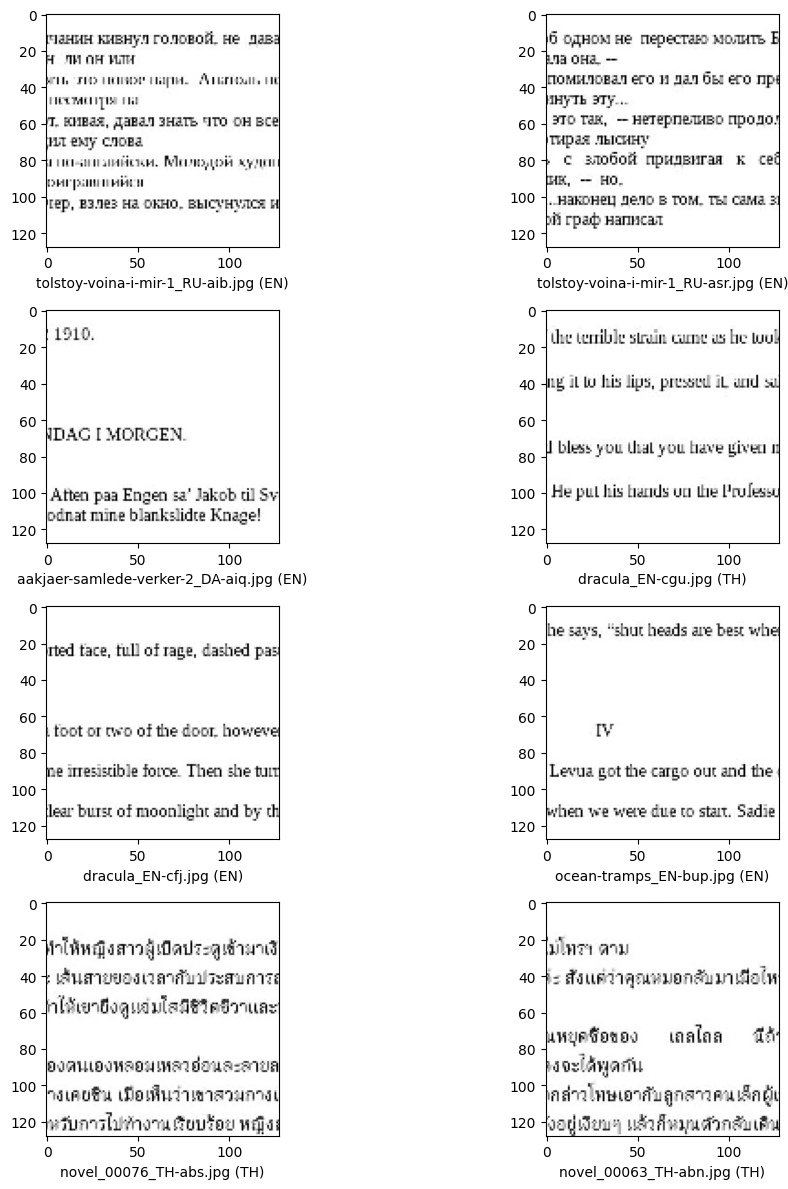

In [14]:
## Print and plot misclassified results
wrongResults = validation_subset[validation_subset.predicted != validation_subset.label]
rows = np.random.choice(wrongResults.index, min(4, wrongResults.shape[0]), replace=False)
print("Example wrong results (validation data)")
print(wrongResults.sample(min(10, wrongResults.shape[0])))

## Plot 4 wrong and 4 correct results
plt.figure(figsize=(12, 12))
index = 1
for row in rows:
    filename = wrongResults.loc[row, 'path']
    predicted = wrongResults.loc[row, 'predicted']
    img = load_img(os.path.join(vroot, filename), target_size=imageSize)
    plt.subplot(4, 2, index)
    plt.imshow(img)
    plt.xlabel(filename + " ({})".format(predicted))
    index += 1
# now show correct results
index = 5
correctResults = validation_subset[validation_subset.predicted == validation_subset.label]
rows = np.random.choice(correctResults.index,
                        min(4, correctResults.shape[0]), replace=False)
for row in rows:
    filename = correctResults.loc[row, 'path']
    predicted = correctResults.loc[row, 'predicted']
    img = load_img(os.path.join(vroot, filename), target_size=imageSize)
    plt.subplot(4, 2, index)
    plt.imshow(img)
    plt.xlabel(filename + " ({})".format(predicted))
    index += 1
plt.tight_layout()
plt.show()

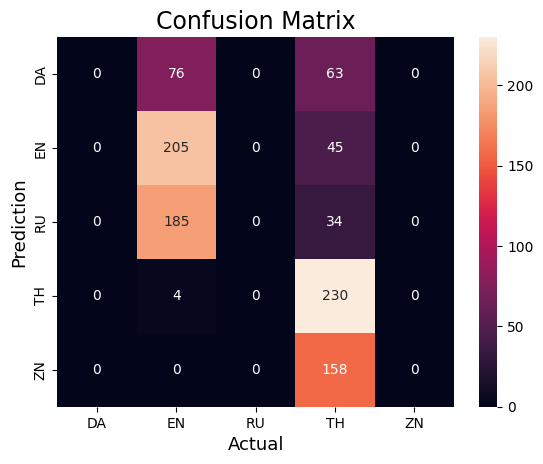

In [22]:
cm = confusion_matrix(validation_subset.label, validation_subset.predicted)
cm_df = pd.DataFrame(cm, columns=np.unique(validation_subset.label), index=np.unique(validation_subset.label))
sns.heatmap(cm_df,
            annot=True,
            fmt='g',
            )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# print(classification_report(y, yhat_word))